<a href="https://colab.research.google.com/github/Nandeesh-U/Deep-learning/blob/main/Nandeesh_Group_8_Kaggle_competition_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

The challenge in this competition is to predict whether a question asked on a well known public forum/platform is Toxic/inappropriate or not.

A toxic/inappropriate question is defined as a question intended to make a statement and not with a purpose of looking for helpful/meaningful answers. The following are some of the characteristics that can signify that a question is irrelevant/inappropriate:

* Based on false information, or contains absurd assumptions
* Does not have a non-neutral tone
* Has an exaggerated tone to underscore a point about a group of people
* Is rhetorical and meant to imply a statement about a group of people
* Is disparaging or inflammatory against an individual or a group of people
* Uses sexual content (such as incest, pedophilia), and not to seek genuine answers
* Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
* Based on an unrealistic premise about a group of people
* Is not grounded in reality

The training dataset includes the questions 1044897 that was asked, and whether it was identified as toxic/inappropriate (target = 1) or as relevant/appropriate (target = 0). The test dataset consists of approximately 261000 questions.

The training data might be imbalanced or noisy. They are not guaranteed to be perfect. Please take the necessary actions/steps while building the model.


## Description

This dataset has the following information:

1. **qid** - unique question identifier
2. **question_text** - the text of the question asked in the well known public forum/platform
3. **target** - a question labeled "toxic/inappropriate" has a value of 1, otherwise 0



## Problem Statement

To perform classification of approximately 261000 questions asked on a well known public form using Deep Neural Networks such as RNN/CNN/BERT/LSTM as 'toxic/inappropriate' questions or 'relevant/appropriate' questions

### 3. Upload your kaggle.json file using the following snippet in a code cell:



In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nandeesh","key":"880f3db1cc68195e9596162707e4b01b"}'}

In [3]:
#If successfully uploaded in the above step, the 'ls' command here should display the kaggle.json file.
%ls

drive/  kaggle.json  sample_data/


### 4. Install the Kaggle API using the following command


In [4]:
#!pip install urllib3

In [ ]:
#!pip install -U -q kaggle==1.5.8

### 5. Move the kaggle.json file into ~/.kaggle, which is where the API client expects your token to be located:



In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
# Execute the following command to verify whether the kaggle.json is stored in the appropriate location: ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [7]:
!chmod 600 /root/.kaggle/kaggle.json # run this command to ensure your Kaggle API token is secure on colab

### 6. Now download the Test Data from Kaggle

In [8]:
#If you get a forbidden link, you have most likely not joined the competition.
!kaggle competitions download -c irrelevant-questions-classification

 97% 59.0M/60.6M [00:03<00:00, 22.7MB/s]
100% 60.6M/60.6M [00:03<00:00, 16.1MB/s]


In [10]:
'''import zipfile
zip_ref = zipfile.ZipFile('/content/irrelevant-questions-classification.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/colab_data_files/kaggle_1_dataset')
zip_ref.close()'''

"import zipfile\nzip_ref = zipfile.ZipFile('/content/irrelevant-questions-classification.zip', 'r')\nzip_ref.extractall('/content/drive/MyDrive/colab_data_files/kaggle_1_dataset')\nzip_ref.close()"

In [9]:
!unzip /content/irrelevant-questions-classification.zip

Archive:  /content/irrelevant-questions-classification.zip
  inflating: sample_submission.csv   
  inflating: test_dataset.csv        
  inflating: train_dataset.csv       


In [ ]:
#!pip install transformers

In [11]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import nltk
from sklearn.metrics import f1_score
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from gensim.utils import simple_preprocess

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder

from keras.layers import Input, Embedding, Dense, Bidirectional, Dropout, GRU, LSTM
from keras.models import Sequential   # the model
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##   **Stage 1**:  Data Loading and Perform Exploratory Data Analysis (1 Points)

Extracting data from a stored folder to maintain consistency across the project

In [12]:
df_train = pd.read_csv("/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/train_dataset.csv")
df_test = pd.read_csv("/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/test_dataset.csv")

In [13]:
df_train.head()

,qid,question_text,target
0,2549b81c4adff1849a7f,Is CSE at bit Meara good?,0
1,0558ed93a4630e68f7ac,Is it better to exercise before or after the b...,0
2,5d72d5233059e44f8a8e,Can character naming in writing infringe on tr...,0
3,3968636ac28841d0c901,Why does everyone making YouTube videos in Jap...,0
4,201d2b9a777bbf25443f,Is there any relation between horse power and ...,0


In [14]:
#Let's check the distribution of target clas
df_train['target'].value_counts()

0    980293
1     64604
Name: target, dtype: int64

The data is heavily skewed. Only 6% of the samples are toxic/inappropriate

In [15]:
df_train.isnull().values.any()

False

no null values exist

In [16]:
df_train.dtypes

qid              object
question_text    object
target            int64
dtype: object

The columns are in the right format

In [17]:
df_train.shape

(1044897, 3)

In [18]:
df_test.shape

(261221, 2)

In [19]:
df_train.tail()

,qid,question_text,target
1044892,b5d282ea587702905154,What are some good websites or apps to learn E...,0
1044893,5518b478efd27015c9b8,Where can one purchase large fireworks in the ...,0
1044894,bc15c3edb963bdb86b9f,Where do I study sat subject in India?,0
1044895,12877d5f68d2eb841c3f,Which team in IPL (1-10) has won all the leagu...,0
1044896,0154ac055e234881dfb7,I know you can't change your personality as a ...,0


In [20]:
df_test.head()

,qid,question_text
0,d5cacbea9be29bd47a78,Is Minance any good?
1,5650c4a236fe3b555c31,Do computers have reserved key strokes?
2,b778db4f09f9326195ea,When was the last time that the US had such a ...
3,e91c299cffc74a66aaf5,Are you still living in Wasilla?
4,2e129e7a85739a73b70a,What distinguishes the acting style of Piolo P...


##   **Stage 2**: Data Pre-Processing  (1 Points)

####  Clean and Transform the data into a specified format


In [21]:
df_train['question_text'] = df_train['question_text'].apply(lambda x:simple_preprocess(x, max_len=30))

In [22]:
df_test['question_text'] = df_test['question_text'].apply(lambda x:simple_preprocess(x, max_len=30))

In [23]:
df_test.shape

(261221, 2)

In [24]:
df_train.tail()

,qid,question_text,target
1044892,b5d282ea587702905154,"[what, are, some, good, websites, or, apps, to...",0
1044893,5518b478efd27015c9b8,"[where, can, one, purchase, large, fireworks, ...",0
1044894,bc15c3edb963bdb86b9f,"[where, do, study, sat, subject, in, india]",0
1044895,12877d5f68d2eb841c3f,"[which, team, in, ipl, has, won, all, the, lea...",0
1044896,0154ac055e234881dfb7,"[know, you, can, change, your, personality, as...",0


In [25]:
# Remove stop words
stop_words = set(stopwords.words('english'))

df_train['question_text'] = df_train['question_text'].apply(lambda x: [w for w in x if not w in stop_words])
df_test['question_text'] = df_test['question_text'].apply(lambda x: [w for w in x if not w in stop_words])

In [26]:
# checking the max word count
tmp_list= [len(i) for i in df_train['question_text']]
print(max(tmp_list))

81


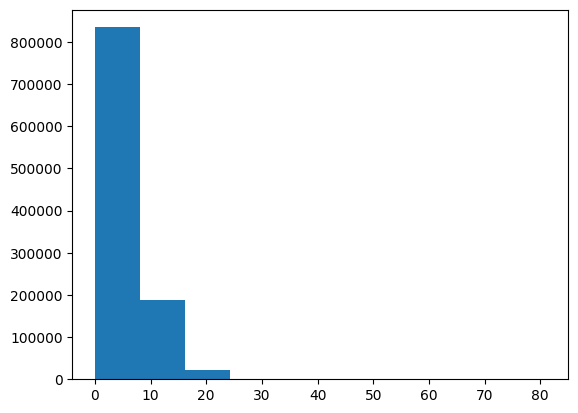

In [27]:
plt.hist(tmp_list)
plt.show()

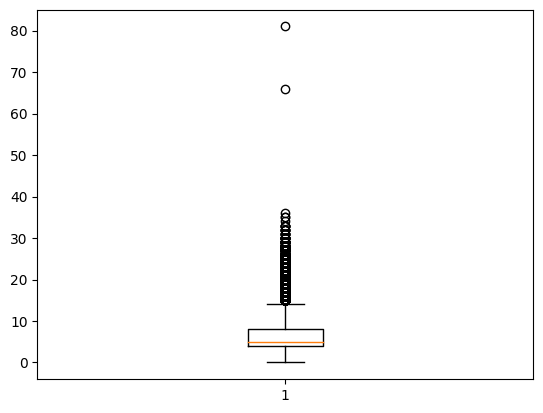

In [28]:
plt.boxplot(tmp_list)
plt.show()

The maximum length of a question_text is 81. Looking at the box plot, a max seq length of 40 would sufficiently cover all the questions. let's select 40 as our max token count per question_text

##   **Stage 3**: Build the Word Embeddings using pretrained Word2vec/Glove (Text Representation) (1 Point)



In [29]:
# Hyperparameters
MAX_SENT_LEN = 40   # Number of words to consider from each question_text
MAX_VOCAB_SIZE = 165000   # Max vocabulary size
BATCH_SIZE = 128
N_EPOCHS = 15

Let's do padding to maintain a consistent input length

In [30]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in df_train['question_text']])

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 160953


In [31]:
# Convert the sequence of words to sequnce of indices
X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in df_train['question_text']])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y = df_train['target']

In [32]:
#deleting dataframes to save RAM
del df_train

In [33]:
len(X[0])

40

In [34]:
print(X)

[[  518  1282 78664 ...     0     0     0]
 [   32  1497  4822 ...     0     0     0]
 [  565  6959   246 ...     0     0     0]
 ...
 [   90  1463   656 ...     0     0     0]
 [  490  2629  1244 ...     0     0     0]
 [   18    76   664 ...     0     0     0]]


In [35]:
print(y)

0          0
1          0
2          0
3          0
4          0
          ..
1044892    0
1044893    0
1044894    0
1044895    0
1044896    0
Name: target, Length: 1044897, dtype: int64


Splitting the train data into train test split

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, train_size=0.9)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((940407, 40), (104490, 40), (940407,), (104490,))

In [38]:
del X

Let's load the 300 dimensional GloVe embedding

In [39]:
#!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
#!wget https://nlp.stanford.edu/data/glove.6B.zip

In [40]:
#!unzip glove*.zip

In [42]:
'''import zipfile
zip_ref = zipfile.ZipFile('/content/glove.6B.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/colab_data_files')
zip_ref.close()'''

"import zipfile\nzip_ref = zipfile.ZipFile('/content/glove.6B.zip', 'r')\nzip_ref.extractall('/content/drive/MyDrive/colab_data_files')\nzip_ref.close()"

In [43]:
'''
embeddings_index = {}
# Loading the 300-dimensional vector of the model
f = open('/content/drive/MyDrive/colab_data_files/glove.6B.300d.txt')
count=0
for line in f:
  try:
    #print(line)
    print(count)
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  except:
    pass
  count+=1
f.close()

print('Found %s word vectors.' % len(embeddings_index))
'''

"\nembeddings_index = {}\n# Loading the 300-dimensional vector of the model\nf = open('/content/drive/MyDrive/colab_data_files/glove.6B.300d.txt')\ncount=0\nfor line in f:\n  try:\n    #print(line)\n    print(count)\n    values = line.split()\n    word = values[0]\n    coefs = np.asarray(values[1:], dtype='float32')\n    embeddings_index[word] = coefs\n  except:\n    pass\n  count+=1\nf.close()\n\nprint('Found %s word vectors.' % len(embeddings_index))\n"

In [44]:
import pickle
'''
pickle.dump({'embeddings_index' : embeddings_index } , open('/content/drive/MyDrive/colab_data_files/glove_embeddings_unpacked.pkl', 'wb'))
'''

"\npickle.dump({'embeddings_index' : embeddings_index } , open('/content/drive/MyDrive/colab_data_files/glove_embeddings_unpacked.pkl', 'wb'))\n"

Loading the embedding dictionary already stored as a pickle file. The key Will be a word and values are the embedded vectors as a python arra

In [45]:
file_to_read = open("/content/drive/MyDrive/colab_data_files/glove_embeddings_unpacked_6b_300d.pkl", "rb")

loaded_dict = pickle.load(file_to_read)

In [46]:
type(loaded_dict)

dict

In [47]:
embeddings_index=loaded_dict['embeddings_index']

In [48]:
len(embeddings_index)

400000

In [49]:
tokenizer

In [50]:
tokenizer.word_index

{'get': 1,
 'best': 2,
 'would': 3,
 'people': 4,
 'like': 5,
 'good': 6,
 'one': 7,
 'india': 8,
 'make': 9,
 'think': 10,
 'many': 11,
 'time': 12,
 'much': 13,
 'life': 14,
 'someone': 15,
 'use': 16,
 'way': 17,
 'know': 18,
 'work': 19,
 'want': 20,
 'take': 21,
 'ever': 22,
 'find': 23,
 'us': 24,
 'world': 25,
 'become': 26,
 'person': 27,
 'without': 28,
 'could': 29,
 'feel': 30,
 'year': 31,
 'better': 32,
 'quora': 33,
 'go': 34,
 'trump': 35,
 'new': 36,
 'possible': 37,
 'job': 38,
 'years': 39,
 'indian': 40,
 'mean': 41,
 'women': 42,
 'used': 43,
 'need': 44,
 'start': 45,
 'first': 46,
 'money': 47,
 'difference': 48,
 'still': 49,
 'different': 50,
 'country': 51,
 'school': 52,
 'long': 53,
 'really': 54,
 'old': 55,
 'learn': 56,
 'business': 57,
 'love': 58,
 'college': 59,
 'things': 60,
 'even': 61,
 'engineering': 62,
 'give': 63,
 'help': 64,
 'day': 65,
 'online': 66,
 'say': 67,
 'men': 68,
 'see': 69,
 'bad': 70,
 'book': 71,
 'using': 72,
 'university': 73,

In [51]:
print(len(tokenizer.word_index))

160953


creating an embeddings matrix where each row represents a word from the vocabulary we obtained from the training data and the colums represent embedding dimensions

In [52]:
# Adding 1 because of reversed 0 index
words_not_found = []
vocab_size = len(tokenizer.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_dim = 300

# Create a weight matrix for words in the training data
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  if i >= vocab_size:
    continue
  embedding_vector = embeddings_index.get(word)
  if (embedding_vector is not None) and len(embedding_vector) > 0:
    embedding_matrix[i] = embedding_vector
  else:
    words_not_found.append(word)

Loaded 400000 word vectors.


In [53]:
len(words_not_found)

64103

64103 new words out of 160000 are there in the questions that doesnot exist in our embeddings from glove. This seems to be a bad embedding for this problem. But we are not able to use bigger pre trained embeddings due to compute issues

##   **Stage 4**: Build and Train the Deep networks model using Pytorch/Keras (5 Points)



Let's first build a Bi directional GRU to establish the baseline

In [54]:
# Build a sequential model by stacking neural net units
model = Sequential()
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights = [embedding_matrix],
                            input_length = MAX_SENT_LEN,
                            trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.50, name='first_gru_layer')))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(64, name='second_gru_layer')))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output_layer'))

In [55]:
print('Summary of the built model...')
model.summary()

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           48286200  
                                                                 
 bidirectional (Bidirection  (None, 40, 256)           330240    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               123648    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)            

Let's train the model

In [56]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

In [ ]:
model.save('/content/drive/MyDrive/colab_data_files/models/bigru_128_64_64.keras')

##   **Stage 5**: Evaluate the Model and get model predictions on the test dataset (2 Points)








Let's evaluate the model on test data for accuracy

We have saved the model for reuse. So loading it here from there.

In [57]:
model = tf.keras.models.load_model('/content/drive/MyDrive/colab_data_files/models/bigru_128_64_64.keras')


In [58]:
print('Testing...')
model.evaluate(X_test, y_test)

Testing...
3266/3266 [==============================] - 28s 7ms/step - loss: 0.1080 - accuracy: 0.9574


[0.10797396302223206, 0.9573930501937866]

In [59]:
# model predictions on the test data
preds = model.predict(X_test)

3266/3266 [==============================] - 19s 6ms/step


In [60]:
preds.shape

(104490, 1)

In [61]:
preds[:10]

array([[1.3618171e-02],
       [3.5211286e-03],
       [7.4215823e-01],
       [6.6390976e-02],
       [1.2783372e-03],
       [2.2721652e-02],
       [8.6614296e-02],
       [1.2570830e-03],
       [5.0524797e-04],
       [2.3280754e-04]], dtype=float32)

Since the data is highly skewed, the default threshold of 0.5 might not be a right approach to determine the classes from probabilities. There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.

Sensitivity = True Positive Rate
Specificity = 1 – False Positive Rate
The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

G-Mean = sqrt(Sensitivity * Specificity)
One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.

In [62]:
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax

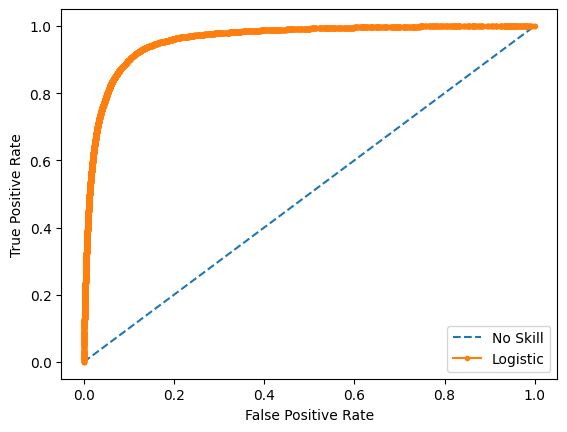

In [63]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, preds)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [64]:
tpr

array([0.00000000e+00, 1.54798762e-04, 3.09597523e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [65]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99902071, 0.99904111,
       1.        ])

In [66]:
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

let's look at the scwtter plot of threshold vs gmeans

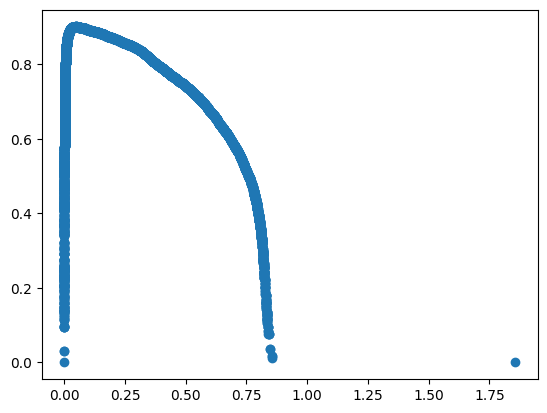

In [67]:
plt.scatter(thresholds, gmeans)
plt.show()

In [68]:
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.047091, G-Mean=0.901


Though, the best value of threshold is 0.047 which gives the highest gmean on test dataset, the curve is not smooth near 0, so it would be a prudent approach to go with a threshold in the smoother part of the curve. Lets do the same analysis on y_train which is a larger dataset.

In [69]:
preds_train = model.predict(X_train)

29388/29388 [==============================] - 183s 6ms/step


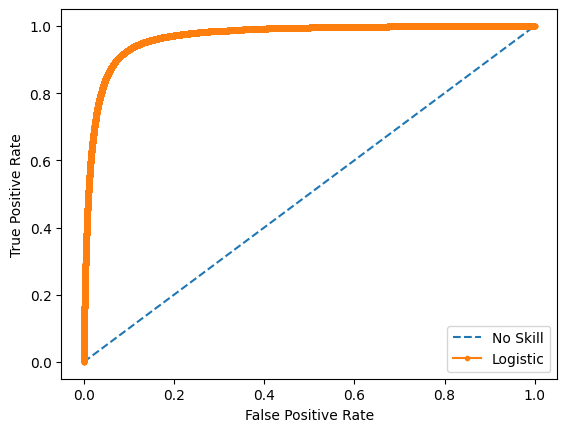

In [70]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, preds_train)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [71]:
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

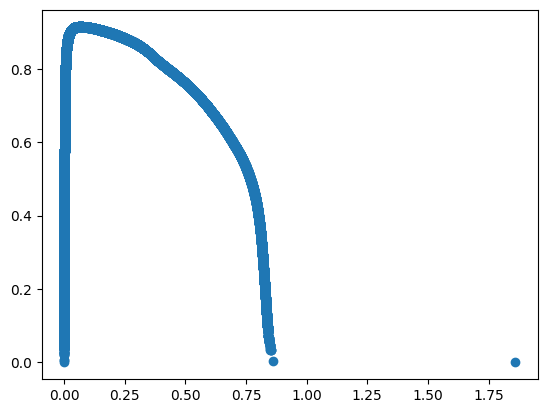

In [72]:
plt.scatter(thresholds, gmeans)
plt.show()

In [73]:
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.065284, G-Mean=0.915


When we used a threshold of 0.15 which seemed to be the best from the scatter plot, the score on kaggle public dataset decreased. Probably, gmean is not a good metric. Let's use f1 score as our metric directly to perform a grid search over the threshold values.

In [74]:
#Let's get the list of threshold values to search over
t = [round(i,1) for i in thresholds]
t =list(set(t))
t =[i for i in t if i<=1]

In [75]:
t

[0.9, 1.9, 0.6, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

In [77]:
f1scores=[]
for threshold in t:
  y_pred = [1 if i>threshold else 0 for i in preds]
  f1scores.append(f1_score(y_test, y_pred))

In [78]:
f1scores

[0.0,
 0.565416111216911,
 0.26219671275763107,
 0.47313448907074407,
 0.6191616766467065,
 0.6418582970789309,
 0.6421472517071192,
 0.6175501647199761,
 0.5710179148914327,
 0.11644885083370887]

In [79]:
#Let's check the same on train data
f1scores=[]
for threshold in t:
  y_pred = [1 if i>threshold else 0 for i in preds_train]
  f1scores.append(f1_score(y_train, y_pred))

In [80]:
f1scores

[0.0,
 0.593331917604587,
 0.2767060595527749,
 0.4951090865499881,
 0.6504267967380535,
 0.6767289542899383,
 0.6783525723243552,
 0.6528867852934715,
 0.5955734635456682,
 0.11645674582469999]

A threshold value of 0.3 seems to be the optimum cutoff for the best f1 score on both test and train dataset

Let's use the learnt model to make predictions on df_test

In [81]:
# Function to get the predictions
def predictions(df_test, threshold):

  questions_list_idx = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in df_test['question_text']])

  # Pad the sequences of the data
  questions_list_idx = pad_sequences(questions_list_idx, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

  # Get the predictons by using GRU model
  review_preds = model.predict(questions_list_idx)

  # Add the predictions to the movie reviews data
  df_test['predictions'] = review_preds

  # Set the threshold for the predictions
  pred_sentiment = np.array(list(map(lambda x : 1 if x > threshold else 0, review_preds)))

  # Add the sentiment predictions to the movie reviews
  df_test['predicted target'] = pred_sentiment

  return df_test

In [82]:
#df_test = predictions(df_test, 0.15)

8164/8164 [==============================] - 54s 7ms/step


In [83]:
df_test = predictions(df_test, 0.3)

8164/8164 [==============================] - 45s 5ms/step


In [84]:
df_test.shape

(261221, 4)

In [85]:
df_test.to_csv('/content/drive/MyDrive/colab_data_files/results/df_test_3.csv', index=False)

In [86]:
df_test.head()

,qid,question_text,predictions,predicted target
0,d5cacbea9be29bd47a78,"[minance, good]",0.006642,0
1,5650c4a236fe3b555c31,"[computers, reserved, key, strokes]",0.006468,0
2,b778db4f09f9326195ea,"[last, time, us, scandal, driven, administration]",0.027501,0
3,e91c299cffc74a66aaf5,"[still, living, wasilla]",0.002543,0
4,2e129e7a85739a73b70a,"[distinguishes, acting, style, piolo, pascual]",0.000760,0


In [87]:
def df_test_to_submission(df_test):
  result=df_test.rename(columns = {'predicted target':'target'})
  result= result[['qid', 'target']]
  return result

In [88]:
submission = df_test_to_submission(df_test)

In [89]:
submission.shape

(261221, 2)

In [90]:
submission.head()

,qid,target
0,d5cacbea9be29bd47a78,0
1,5650c4a236fe3b555c31,0
2,b778db4f09f9326195ea,0
3,e91c299cffc74a66aaf5,0
4,2e129e7a85739a73b70a,0


Some issueexists in the submission file in kaggle. There are 23 qids which does not exist in test datasetbut are expected in the sample submission files. so we are going to default these 23 entries to the target value of '0' to make valid submission

In [91]:
sample_df = pd.read_csv('/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/sample_submission.csv')

In [92]:
sub_df = pd.read_csv('/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/test_dataset.csv')

In [93]:
sample_df.shape

(261221, 2)

In [94]:
problematic_qids =list(set(sample_df['qid'].values)-set(sub_df['qid'].values))

In [95]:
problematic_qids

['8.72E+19',
 '9.07E+19',
 '5.68E+19',
 '1.98E+18',
 '9.08E+19',
 '4.64E+19',
 '4.93E+19',
 '6.32E+19',
 '3.83E+18',
 '2.73E+19',
 '7.06E+19',
 '7.03E+19',
 '8.81E+19',
 '7.32E+19',
 '7.57E+19',
 '3.86E+19',
 '7.85E+18',
 '8.19E+19',
 '8.70E+19',
 '9.00E+19',
 '4.59E+19',
 '9.98E+19',
 '5.56E+19']

In [96]:
len(problematic_qids)

23

In [97]:
submission.shape

(261221, 2)

In [98]:
for qid in problematic_qids:
  row = pd.Series([qid, 0], index = submission.columns)
  submission = submission.append(row, ignore_index=True)

<ipython-input-98-f62e785e1637>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-98-f62e785e1637>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-98-f62e785e1637>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-98-f62e785e1637>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-98-f62e785e1637>:3: FutureWarning: The frame.append method is deprecated and will be 

In [99]:
submission.shape

(261244, 2)

In [100]:
#Let's remove those entries in submission which are not there in sample submission file
extra_qids =list(set(submission['qid'].values)-set(sample_df['qid'].values))
len(extra_qids)


23

In [101]:
submission =submission[submission['qid'].isin(list(sample_df['qid'].values))]

In [102]:
submission.shape

(261221, 2)

In [103]:
submission.to_csv('/content/drive/MyDrive/colab_data_files/results/submission_3.csv', index=False)

# ***Lets train an LSTM to see if the performance improves***

We will not remove stopwords now from the question text in the LSTM model. Since the problem is to find toxic/inappropriate questions, words like 'is', 'what', 'why' might be useful .

In [104]:
df_train = pd.read_csv("/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/train_dataset.csv")
df_test = pd.read_csv("/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/test_dataset.csv")

In [105]:
df_train['question_text'] = df_train['question_text'].apply(lambda x:simple_preprocess(x, max_len=30))
df_test['question_text'] = df_test['question_text'].apply(lambda x:simple_preprocess(x, max_len=30))


In [106]:
# Hyperparameters
MAX_SENT_LEN = 40   # Number of words to consider from each question_text
MAX_VOCAB_SIZE = 165000   # Max vocabulary size
BATCH_SIZE = 128
N_EPOCHS = 15

In [107]:
#Let's do padding to maintain a consistent input length
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in df_train['question_text']])

print("Number of words in vocabulary:", len(tokenizer.word_index))

# Convert the sequence of words to sequnce of indices
X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in df_train['question_text']])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y = df_train['target']


Number of words in vocabulary: 161023


In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, train_size=0.9)

In [109]:
#Let's load the 300 dimensional GloVe embedding
import pickle
file_to_read = open("/content/drive/MyDrive/colab_data_files/glove_embeddings_unpacked_6b_300d.pkl", "rb")

loaded_dict = pickle.load(file_to_read)
embeddings_index=loaded_dict['embeddings_index']



In [110]:
# creating an embeddings matrix where each row represents a word from the vocabulary we obtained from the training data and the colums represent embedding dimensions
# Adding 1 because of reversed 0 index
words_not_found = []
vocab_size = len(tokenizer.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_dim = 300

# Create a weight matrix for words in the training data
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  if i >= vocab_size:
    continue
  embedding_vector = embeddings_index.get(word)
  if (embedding_vector is not None) and len(embedding_vector) > 0:
    embedding_matrix[i] = embedding_vector
  else:
    words_not_found.append(word)



Loaded 400000 word vectors.


In [111]:
len(words_not_found)

64068

In [112]:
# Build a sequential model by stacking neural net units
model2 = Sequential()
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights = [embedding_matrix],
                            input_length = MAX_SENT_LEN,
                            trainable=False)
model2.add(embedding_layer)
model2.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.50, name='first_lstm_layer')))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(64, name='second_lstm_layer')))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid', name='output_layer'))

In [113]:
print('Summary of the built model...')
model2.summary()

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 300)           48307200  
                                                                 
 bidirectional_2 (Bidirecti  (None, 40, 256)           439296    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 40, 256)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)        

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model2.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

In [ ]:
model2.save('/content/drive/MyDrive/colab_data_files/models/bilstm_128_64_64.keras')

We have saved the model for re-use. So loading it from there.

In [114]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/colab_data_files/models/bilstm_128_64_64.keras')


In [115]:
# model predictions on the test data
preds = model2.predict(X_test)


3266/3266 [==============================] - 20s 6ms/step


In [116]:
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax

In [117]:
t=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [118]:
f1scores=[]
for threshold in t:
  y_pred = [1 if i>threshold else 0 for i in preds]
  f1scores.append(f1_score(y_test, y_pred))

In [119]:
f1scores

[0.11644885083370887,
 0.5660286156225831,
 0.6303803233887496,
 0.6610616137532941,
 0.6728671796587488,
 0.6792235801581596,
 0.667819253438114,
 0.6345297353942887,
 0.5335775335775336,
 0.29763880025526485]

In [120]:
# model predictions on the test data
preds_train = model2.predict(X_train)


29388/29388 [==============================] - 172s 6ms/step


In [121]:
#Let's check the same on train data
f1scores=[]
for threshold in t:
  y_pred = [1 if i>threshold else 0 for i in preds_train]
  f1scores.append(f1_score(y_train, y_pred))

In [122]:
f1scores

[0.11645674582469999,
 0.596992034561901,
 0.6713997865042921,
 0.7076240950500536,
 0.725164391236399,
 0.7355657373365202,
 0.7291616165114104,
 0.6936702517250685,
 0.5897099548170821,
 0.33174768485940276]

A threshold value of 0.5 seems to be the optimum cutoff for the best f1 score on both test and train dataset

Let's use the learnt model to make predictions on df_test

In [123]:
# Function to get the predictions
def predictions(df_test, threshold):

  questions_list_idx = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in df_test['question_text']])

  # Pad the sequences of the data
  questions_list_idx = pad_sequences(questions_list_idx, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

  # Get the predictons by using GRU model
  review_preds = model2.predict(questions_list_idx)

  # Add the predictions to the movie reviews data
  df_test['predictions'] = review_preds

  # Set the threshold for the predictions
  pred_sentiment = np.array(list(map(lambda x : 1 if x > threshold else 0, review_preds)))

  # Add the sentiment predictions to the movie reviews
  df_test['predicted target'] = pred_sentiment

  return df_test

In [124]:
df_test = predictions(df_test, 0.5)
df_test.to_csv('/content/drive/MyDrive/colab_data_files/results/df_test_4.csv', index=False)

8164/8164 [==============================] - 46s 6ms/step


In [125]:
def df_test_to_submission(df_test):
  result=df_test.rename(columns = {'predicted target':'target'})
  result= result[['qid', 'target']]
  return result

In [126]:
submission = df_test_to_submission(df_test)

Some issue exists in the submission file in kaggle. There are 23 qids which does not exist in test dataset but are expected in the sample submission files. so we are going to default these 23 entries to the target value of '0' to make valid submission

In [127]:
sample_df = pd.read_csv('/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/sample_submission.csv')
sub_df = pd.read_csv('/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/test_dataset.csv')
problematic_qids =list(set(sample_df['qid'].values)-set(sub_df['qid'].values))
print(len(problematic_qids))
for qid in problematic_qids:
  row = pd.Series([qid, 0], index = submission.columns)
  submission = submission.append(row, ignore_index=True)

submission =submission[submission['qid'].isin(list(sample_df['qid'].values))]
print(submission.shape)




23


<ipython-input-127-3419ac1f0588>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-127-3419ac1f0588>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-127-3419ac1f0588>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-127-3419ac1f0588>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(row, ignore_index=True)
<ipython-input-127-3419ac1f0588>:7: FutureWarning: The frame.append method is deprecated and wil

(261221, 2)


In [128]:
submission.to_csv('/content/drive/MyDrive/colab_data_files/results/submission_4.csv', index=False)

# **The above file is our final version of submission. We could not complete BERT training due to copute issues**

# ***Lets train a BERT model to see if the accuracy improves further***

In [130]:
#!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 8.7 MB/s eta 0:00:00


In [131]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [132]:
df_train = pd.read_csv("/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/train_dataset.csv")
df_test = pd.read_csv("/content/drive/MyDrive/colab_data_files/kaggle_1_dataset/test_dataset.csv")

tr_texts = df_train['question_text'].to_list()
te_texts = df_test['question_text'].to_list()

tr_labels=df_train['target'].to_list()


In [133]:
#Lets Create a custom dataset class for text classification
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length
  def __len__(self):
    return len(self.texts)
  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}



In [134]:
#Build our customer BERT classifier
class BERTClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes):
    super(BERTClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

In [135]:
#Define the train() function
def train(model, data_loader, optimizer, scheduler, device):
  model.train()
  for batch in data_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [136]:
# Build our evaluation method
def evaluate(model, data_loader, device):
  model.eval()
  predictions = []
  actual_labels = []
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds.cpu().tolist())
      actual_labels.extend(labels.cpu().tolist())
  return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [137]:
#Build our prediction method
def predict_toxicity(text, model, tokenizer, device, max_length=128):
  model.eval()
  encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
  input_ids = encoding['input_ids'].to(device)
  attention_mask = encoding['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
  return 1 if preds.item() == 1 else 0




In [138]:
#Define our model’s parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 40
num_epochs = 5
learning_rate = 2e-5




In [139]:
#Loading and splitting the data.
train_texts, val_texts, train_labels, val_labels = train_test_split(tr_texts, tr_labels, test_size=0.2, random_state=42)


In [140]:
#Initialize tokenizer, dataset, and data loader
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [142]:
#Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#Training the model
for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")
  train(model, train_dataloader, optimizer, scheduler, device)
  accuracy, report = evaluate(model, val_dataloader, device)
  print(f"Validation Accuracy: {accuracy:.4f}")
  print(report)


The model is failing in training because it takes a lot of time to train. The compute provided by collab stops running midway.

In [ ]:
torch.save(model.state_dict(), "bert_classifier.pth")